/Users/agpascoemacmini3/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


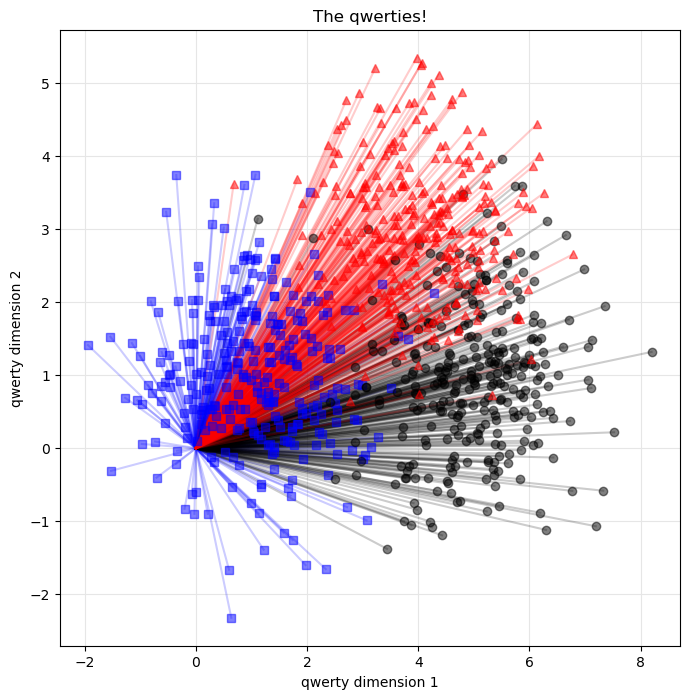

In [1]:
from ml_toolkit import myfunctions
myfunctions.createData()
